## hetGPy Sequential Learning
## hetGPy Sequential Updating
This notebook illustrates the use of the `update` module in `hetGPy`

Model updates are on the order of $O(n^2)$ which is faster than the full training size of $O(n^3)$

In [1]:
######## Libraries #########
##  Numerical
import numpy as np
from rpy2.robjects import r
rand = np.random.default_rng(42)
from hetgpy.hetGP import hetGP
from copy import copy
from scipy.stats import norm
def noise_fun(x,coef=1):
    return coef * (0.05 + np.sqrt(np.abs(x)*20/(2*np.pi))/10)
## Plotting
import os
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_formats = ['svg']
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
#############################

r('''
library(hetGP)
set.seed(42)
## Spatially varying noise function
noisefun <- function(x, coef = 1){
return(coef * (0.05 + sqrt(abs(x)*20/(2*pi))/10))
}

## Initial data set
nvar <- 1
n <- 10
X <- matrix(seq(0, 0.1, length=n), ncol = 1)
mult <- sample(1:5, n, replace = TRUE)
X <- rep(X, mult)
Z <- f1d_n(X)

## Initial fit
testpts <- matrix(seq(0, 1, length = 10*n), ncol = 1)
Ztrue <- f1d(testpts)
model <- model_init <- mleHetGP(X = X, Z = Z, lower = rep(0.1, nvar), 
upper = rep(5, nvar), maxit = 1000)
nsteps <- 20
npersteps <- 3
step <- 1
interval_size = as.integer(length(testpts)/nsteps)
interval <- 1:interval_size
''')
X = np.array(r('X')).reshape(-1,1)
Z = np.array(r('Z'))
n = 10
testpts = np.array(r('testpts'))
model = hetGP()
model.mleHetGP(
    X = X,
    Z = Z,
    lower = 0.1 + 0.0*np.arange(X.shape[1]),
    upper = 5 + 0.0*np.arange(X.shape[1]),
    maxit = 500,
    settings = {'checkHom':False}
)
model_init = copy(model)
nsteps = np.array(r('nsteps')).astype(int)[0]

for i in range(nsteps):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (11.5,8),sharey=True)
    r('''
    interval <- pmin(interval + interval_size,length(testpts))
    newIds <- sort(sample(interval, npersteps,replace=F))
    newmult <- sample(1:5,length(newIds), replace = T)
    newIds <- rep(newIds,newmult)
    newX <- testpts[newIds, ,drop = FALSE] 
    newZ <- f1d_n(newX)
    model <- update(object = model, Xnew = newX, Znew = newZ)
    X <- c(X, newX)
    Z <- c(Z, newZ)
    ''')
    # plot true test function
    ax.scatter(testpts.squeeze(),np.array(r('Ztrue')),alpha=0.2,color='red',label = 'True')
    # plot before
    ax.scatter(X.squeeze().copy(),Z.copy(), alpha = 0.5, color = 'black',label = 'Initial Data')
    
    
    newX = np.array(r('newX')).reshape(-1,1)
    newZ = np.array(r('newZ'))
    model.update(Xnew = newX, Znew = newZ.squeeze(),maxit=500,lower = np.array([0.1]), upper = np.array([5]))
    X = np.vstack([X,newX])        
    Z = np.hstack([Z,newZ.squeeze()])

    ax.scatter(newX.squeeze().copy(),newZ.copy(), alpha = 1.0, color = 'black',label = 'New Data')
    preds = model.predict(testpts)
    preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
    preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze() 
    ax.plot(testpts.squeeze(),preds['mean'],color='blue',label='Predicted Mean')
    ax.plot(testpts.squeeze(),preds['lower'],color='blue',linestyle='dashed')
    ax.plot(testpts.squeeze(),preds['upper'],color='blue',linestyle='dashed')
    ax.set_title(f'Iter {i}')
    ax.set_ylim(bottom = -10, top = 10)
    ax.legend(loc='upper left')
    fig.tight_layout()
    if not os.path.exists('png'): os.makedirs('png')
    #fig.savefig(f"png/Sequential-update-iter-{i:03}.pdf")
    fig.savefig(f"png/Sequential-update-iter-{i:03}.png",dpi=500)
    plt.close(fig)

Homoskedastic model has higher log-likelihood: 
 -59.49728  compared to  -61.07685 
Return homoskedastic model 
Homoskedastic model has higher log-likelihood: 
 -59.49727641675773  compared to  -60.44180596772554 



If you have `ffmpeg` installed, you can make a short movie of the sequential learning:

In [2]:
! ffmpeg -y -framerate 1 -pattern_type glob -i 'png/*.png' -crf 1 -vf format=yuv420p -movflags +faststart png/Sequential-movie.mp4 >/dev/null 2>&1

In [3]:
from IPython.display import Video
Video('png/Sequential-movie.mp4',width=500,height=500)

We can also compare the fit to a "Full" model that trains on all of the data once:

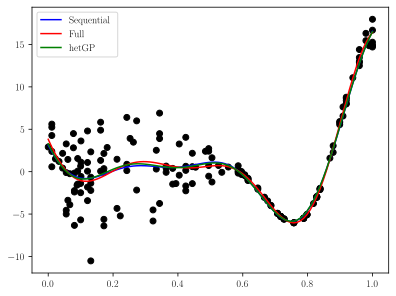

In [4]:
full_model = hetGP().mleHetGP(
    X = X,
    Z = Z,
    lower = 0.1 + 0.0*np.arange(X.shape[1]),
    upper = 5 + 0.0*np.arange(X.shape[1]),
    maxit = 500
)
full_preds = full_model.predict(testpts)
# data
fig, ax = plt.subplots()

ax.scatter(X,Z,color='black')
xs = testpts.squeeze()
fp = preds['mean']
rp = np.array(r('predict(x=testpts,object=model)$mean'))
bp = full_preds['mean']
ax.plot(xs,fp,color='blue',label='Sequential')
ax.plot(xs,bp,color='red',label='Full')
ax.plot(xs,rp,color='green',label='hetGP')
ax.legend()